In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.tree

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.2


In [412]:
plt.figure()
plt.rcParams.update({'font.size':12})
plt.show()
plt.close();

<Figure size 1008x720 with 0 Axes>

In [3]:
import sklearn.model_selection

In [4]:
import pandas as pd

In [5]:
# !pip install pycbc

In [6]:
import pycbc.waveform

In [7]:
def m1_m2_M_q(M, q):
    """
    Assumes m1 >= m2
    Computes the component masses m1 and m2
    from the total mass and mass-ratio.
    input: M, q
    output: m1, m2
    """
    m1 = M*q/(1.+q)
    m2 = M/(1.+q)
    return m1, m2

In [8]:
# def get_peak_amp(q, spin1z, spin2z, M=100, approximant="IMRPhenomT", delta_t=1/2048., f_lower=20, distance=1e-18):
#     mass1, mass2 = m1_m2_M_q(M, q)
#     hp, hc = pycbc.waveform.get_td_waveform(approximant=approximant, mass1=mass1, mass2=mass2, spin1z=spin1z, spin2z=spin2z, delta_t=delta_t, f_lower=f_lower, distance=distance)
#     amp = pycbc.waveform.utils.amplitude_from_polarizations(hp, hc)
#     return amp.max()


def get_peak_amp(q, spin1x, spin2x, M=100, approximant="IMRPhenomTP", delta_t=1/2048., f_lower=20, distance=1e-18):
    mass1, mass2 = m1_m2_M_q(M, q)
    hp, hc = pycbc.waveform.get_td_waveform(approximant=approximant, mass1=mass1, mass2=mass2, spin1x=spin1x, spin2x=spin2x, delta_t=delta_t, f_lower=f_lower, distance=distance)
    amp = pycbc.waveform.utils.amplitude_from_polarizations(hp, hc)
    return amp.max()



# def get_peak_amp(q, spin1z, spin2z, M=100, approximant="IMRPhenomT", delta_t=1/2048., f_lower=20, distance=1e-18):

#     return 4.4 + 3.3*q + 10.2*spin1z - 13.2*spin2z



In [9]:
# get_peak_amp(q=1, spin1z=0, spin2z=0)

In [10]:
# N = 10
# # N = 100
# q_grid = np.linspace(1, 10, N)
# spin1z_grid = np.linspace(-0.99, 0.99, N)
# spin2z_grid = np.linspace(-0.99, 0.99, N)

# p0, p1, p2 = np.meshgrid(q_grid, spin1z_grid, spin2z_grid)

# p0 = p0.ravel()
# p1 = p1.ravel()
# p2 = p2.ravel()

# p_grid = np.c_[p0, p1, p2]

In [80]:
# N = 2
# N = 10
# N = 20
N = 50
# N = 100
q_grid = np.linspace(4, 10, N)
spin1x_grid = np.linspace(0, 0.99, N)
spin2x_grid = np.linspace(0, 0.99, N)

p0, p1, p2 = np.meshgrid(q_grid, spin1x_grid, spin2x_grid)

p0 = p0.ravel()
p1 = p1.ravel()
p2 = p2.ravel()

p_grid = np.c_[p0, p1, p2]

In [81]:
p_grid.shape

(125000, 3)

In [82]:
%%time
# amps = [get_peak_amp(q=q, spin1z=spin1z, spin2z=spin2z, approximant="IMRPhenomT", f_lower=20, delta_t=1/1024.) for q, spin1z, spin2z in p_grid]
amps = [get_peak_amp(q=q, spin1x=spin1x, spin2x=spin2x, approximant="IMRPhenomTP", f_lower=20, delta_t=1/1024.) for q, spin1x, spin2x in p_grid]
amps = np.array(amps)

CPU times: user 2min 22s, sys: 961 ms, total: 2min 23s
Wall time: 2min 23s


In [83]:
plt.scatter(p_grid[:,0], p_grid[:,1], c=amps)
plt.colorbar()

In [84]:
dfX = pd.DataFrame(data=p_grid, columns=['q', 's1', 's2'])
dfy = pd.Series(data=amps, name='amp')

In [85]:
dfX.sample()

q        s1        s2
8974  7.55102  0.060612  0.484898

In [329]:
def build_unsupervised_decision_tree_dataset(X: pd.DataFrame):
    """
    y == 1 means data is real
    y == 0 means data is synthetic

    bootstrap sample from marginals
    """

    x_synths = []
    for col in X.columns:
        x_synths.append(X[col].sample(frac=1, replace=True).values)
    x_synths = np.c_[x_synths].T
    print(x_synths.shape)
    
    X_out = pd.DataFrame(data=np.r_[X.values, x_synths], columns=X.columns)
    y_out = np.concatenate((np.ones(len(X)), np.zeros(len(x_synths))))
    y_out = pd.Series(y_out, name='y')

    return X_out, y_out

In [506]:
X_udt, y_udt = build_unsupervised_decision_tree_dataset(dfX)

(125000, 3)


In [507]:
X_udt.shape

(250000, 3)

In [508]:
y_udt.shape

(250000,)

In [509]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_udt, y_udt, test_size=0.33, random_state=42)

In [510]:
# clf = sklearn.tree.DecisionTreeClassifier(min_samples_split=0.5, min_samples_leaf=100).fit(X_train, y_train)
# clf_new = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=100).fit(X_train, y_train)
# clf = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=100).fit(X_train, y_train)


# clf = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10000).fit(X_train, y_train)
# clf = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=5000).fit(X_train, y_train)
# clf = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=1000).fit(X_train, y_train)
clf = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=100).fit(X_train, y_train)

In [511]:
clf.score(X_test, y_test)

0.47895757575757575

In [512]:
leaf_nodes = pd.DataFrame(data=clf.apply(dfX), columns=['leaf'])

In [513]:
leaf_nodes.value_counts()

leaf
1075    175
2443    168
2417    168
1474    168
671     165
       ... 
1151     63
488      60
197      60
1292     60
80       58
Length: 1233, dtype: int64

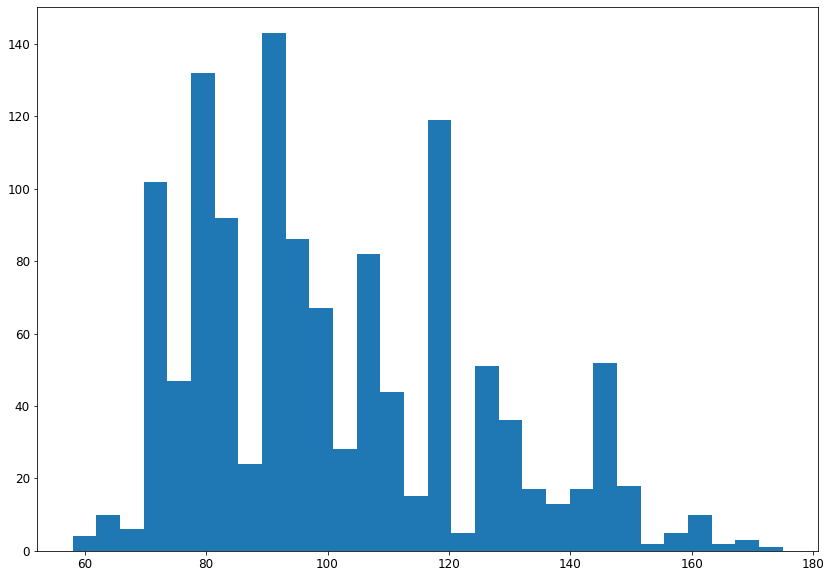

In [514]:
plt.hist(leaf_nodes.value_counts(), bins=30);

In [515]:
# index to leaf_id
leaf_dict = leaf_nodes.value_counts().reset_index()['leaf'].to_dict()
leaf_dict

{0: 1075,
 1: 2443,
 2: 2417,
 3: 1474,
 4: 671,
 5: 849,
 6: 1768,
 7: 532,
 8: 857,
 9: 1509,
 10: 734,
 11: 1385,
 12: 1102,
 13: 1534,
 14: 30,
 15: 428,
 16: 639,
 17: 2058,
 18: 2392,
 19: 1554,
 20: 2397,
 21: 1096,
 22: 87,
 23: 1870,
 24: 2049,
 25: 877,
 26: 232,
 27: 173,
 28: 1436,
 29: 216,
 30: 1374,
 31: 198,
 32: 2338,
 33: 1990,
 34: 1556,
 35: 288,
 36: 145,
 37: 2340,
 38: 1747,
 39: 1107,
 40: 1109,
 41: 998,
 42: 2281,
 43: 1784,
 44: 1787,
 45: 2009,
 46: 1805,
 47: 809,
 48: 742,
 49: 1806,
 50: 1985,
 51: 2303,
 52: 394,
 53: 1840,
 54: 444,
 55: 482,
 56: 483,
 57: 494,
 58: 495,
 59: 302,
 60: 496,
 61: 2288,
 62: 1841,
 63: 238,
 64: 303,
 65: 2019,
 66: 304,
 67: 678,
 68: 2464,
 69: 346,
 70: 2251,
 71: 947,
 72: 1183,
 73: 1182,
 74: 946,
 75: 2157,
 76: 1217,
 77: 1457,
 78: 1473,
 79: 924,
 80: 1413,
 81: 2126,
 82: 1477,
 83: 1120,
 84: 1223,
 85: 1417,
 86: 2150,
 87: 1367,
 88: 1946,
 89: 1495,
 90: 1965,
 91: 1514,
 92: 2094,
 93: 775,
 94: 244,
 95:

In [516]:
dfX_leaf = pd.merge(dfX, leaf_nodes, left_index=True, right_index=True)

In [517]:
dfX_leaf

q    s1        s2  leaf
0        4.0  0.00  0.000000    11
1        4.0  0.00  0.020204    11
2        4.0  0.00  0.040408    11
3        4.0  0.00  0.060612    11
4        4.0  0.00  0.080816    14
...      ...   ...       ...   ...
124995  10.0  0.99  0.909184  2464
124996  10.0  0.99  0.929388  2464
124997  10.0  0.99  0.949592  2464
124998  10.0  0.99  0.969796  2464
124999  10.0  0.99  0.990000  2464

[125000 rows x 4 columns]

In [518]:
X_train, X_test, y_train, y_test = {}, {}, {}, {}
for k, v in leaf_dict.items():
    print(k, v)
    mask = dfX_leaf['leaf'] == v
    X = dfX_leaf[mask].drop(columns='leaf')
    y = dfy[mask]
    X_train[v], X_test[v], y_train[v], y_test[v] = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

0 1075
1 2443
2 2417
3 1474
4 671
5 849
6 1768
7 532
8 857
9 1509
10 734
11 1385
12 1102
13 1534
14 30
15 428
16 639
17 2058
18 2392
19 1554
20 2397
21 1096
22 87
23 1870
24 2049
25 877
26 232
27 173
28 1436
29 216
30 1374
31 198
32 2338
33 1990
34 1556
35 288
36 145
37 2340
38 1747
39 1107
40 1109
41 998
42 2281
43 1784
44 1787
45 2009
46 1805
47 809
48 742
49 1806
50 1985
51 2303
52 394
53 1840
54 444
55 482
56 483
57 494
58 495
59 302
60 496
61 2288
62 1841
63 238
64 303
65 2019
66 304
67 678
68 2464
69 346
70 2251
71 947
72 1183
73 1182
74 946
75 2157
76 1217
77 1457
78 1473
79 924
80 1413
81 2126
82 1477
83 1120
84 1223
85 1417
86 2150
87 1367
88 1946
89 1495
90 1965
91 1514
92 2094
93 775
94 244
95 531
96 530
97 1001
98 257
99 1059
100 1085
101 1812
102 2268
103 751
104 858
105 820
106 819
107 1234
108 1709
109 944
110 310
111 463
112 2093
113 682
114 681
115 762
116 2211
117 266
118 574
119 316
120 1189
121 588
122 180
123 1147
124 1962
125 2456
126 450
127 605
128 2054
129 618


In [519]:
plt.hist(dfy)

(array([22803., 30680., 26247., 17935.,  9007.,  6382.,  4723.,  3477.,
         2363.,  1383.]),
 array([0.17606239, 0.23093008, 0.28579776, 0.34066545, 0.39553313,
        0.45040082, 0.50526851, 0.56013619, 0.61500388, 0.66987156,
        0.72473925]),
 <BarContainer object of 10 artists>)

In [520]:
# should add normalisation...
# horsepower = np.array(train_features['Horsepower'])

# horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
# horsepower_normalizer.adapt(horsepower)

In [521]:
def build_and_compile_model(input_shape=3, units=128, activation='relu'):
    model = keras.Sequential([
      layers.Input(shape=(input_shape,)),
      layers.Dense(units, activation=activation),
      layers.Dense(units, activation=activation),
      layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [522]:
X_train_full, X_test_full, y_train_full, y_test_full = sklearn.model_selection.train_test_split(dfX, dfy, test_size=0.33, random_state=42)

In [523]:
epochs=100
# batch_size=32
# batch_size=320
batch_size=1000

In [524]:
%%time
model_full = build_and_compile_model(units=128)

history = model_full.fit(
    X_train_full,
    y_train_full,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=1, epochs=epochs)

Epoch 1/100


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/engine/data_adapter.py:1508: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


67/67 [==============================] - 1s 7ms/step - loss: 0.1088 - val_loss: 0.0674
Epoch 2/100
67/67 [==============================] - 0s 5ms/step - loss: 0.0529 - val_loss: 0.0423
Epoch 3/100
67/67 [==============================] - 0s 5ms/step - loss: 0.0362 - val_loss: 0.0322
Epoch 4/100
67/67 [==============================] - 0s 5ms/step - loss: 0.0316 - val_loss: 0.0241
Epoch 5/100
67/67 [==============================] - 0s 5ms/step - loss: 0.0242 - val_loss: 0.0518
Epoch 6/100
67/67 [==============================] - 0s 5ms/step - loss: 0.0361 - val_loss: 0.0425
Epoch 7/100
67/67 [==============================] - 0s 5ms/step - loss: 0.0548 - val_loss: 0.0245
Epoch 8/100
67/67 [==============================] - 0s 4ms/step - loss: 0.0225 - val_loss: 0.0179
Epoch 9/100
67/67 [==============================] - 0s 5ms/step - loss: 0.0167 - val_loss: 0.0141
Epoch 10/100
67/67 [==============================] - 0s 5ms/step - loss: 0.0343 - val_loss: 0.0669
Epoch 11/100
67/67 [=

In [525]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [526]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [527]:
model_full_results = {}
for k in X_test.keys():
    model_full_results[k] = [model_full.evaluate(X_test[k], y_test[k], verbose=0)]

In [528]:
model_full_results

{1075: [0.004419020842760801],
 2443: [0.008534673601388931],
 2417: [0.004921772982925177],
 1474: [0.007673627696931362],
 671: [0.00406258599832654],
 849: [0.009611798450350761],
 1768: [0.006970523856580257],
 532: [0.004869021475315094],
 857: [0.0074276914820075035],
 1509: [0.005425394047051668],
 734: [0.002958552446216345],
 1385: [0.0059028505347669125],
 1102: [0.007259245961904526],
 1534: [0.005818145349621773],
 30: [0.008354648016393185],
 428: [0.0035913283936679363],
 639: [0.0034236633218824863],
 2058: [0.004886909853667021],
 2392: [0.005185576621443033],
 1554: [0.009473267011344433],
 2397: [0.007082649506628513],
 1096: [0.017907483503222466],
 87: [0.004301003646105528],
 1870: [0.002569332020357251],
 2049: [0.00594694958999753],
 877: [0.0037536551244556904],
 232: [0.007348884362727404],
 173: [0.007199565414339304],
 1436: [0.007984969764947891],
 216: [0.00503514101728797],
 1374: [0.0037156445905566216],
 198: [0.0035972141195088625],
 2338: [0.0115857021

In [529]:
model_full_results=pd.DataFrame.from_dict(model_full_results, orient='index', columns=['full_model'])

In [530]:
model_full_results

full_model
1075    0.004419
2443    0.008535
2417    0.004922
1474    0.007674
671     0.004063
...          ...
1151    0.007544
488     0.005553
197     0.003643
1292    0.005435
80      0.004572

[1233 rows x 1 columns]

In [531]:
model_full.evaluate(X_test_full, y_test_full, verbose=0)

0.0060180434957146645

In [532]:
# %%time
# models={}
# historys={}
# for k in X_train.keys():
#     print(k)
#     models[k] = build_and_compile_model()

#     historys[k] = models[k].fit(
#         X_train[k],
#         y_train[k],
#         batch_size=batch_size,
#         validation_split=0.2,
#         verbose=0,
#         # epochs=epochs
#         epochs=2
#     )

In [533]:
# for k in X_train.keys():
#     plt.figure()
#     plt.plot(historys[k].history['loss'])
#     plt.plot(historys[k].history['val_loss'])
#     plt.show()
#     plt.close()

In [534]:
# models_results = {}
# for k in X_test.keys():
#     print(k)
#     models_results[k] = [models[k].evaluate(X_test[k], y_test[k], verbose=0)]

In [535]:
# models_results

In [536]:
# models_results=pd.DataFrame.from_dict(models_results, orient='index', columns=['leaf_models'])

In [537]:
# results = pd.concat((model_full_results, models_results), axis=1)
results = model_full_results.copy()

In [538]:
results

full_model
1075    0.004419
2443    0.008535
2417    0.004922
1474    0.007674
671     0.004063
...          ...
1151    0.007544
488     0.005553
197     0.003643
1292    0.005435
80      0.004572

[1233 rows x 1 columns]

In [539]:
results.plot(kind='bar')

<AxesSubplot:>

In [540]:
# plt.figure()
# for k in X_train.keys():
#     plt.plot(historys[k].history['loss'], label=k)
#     # plt.plot(historys[k].history['val_loss'], ls='--')
# plt.plot(history.history['loss'], label='full')
# plt.legend()
# plt.show()
# plt.close()

In [541]:
# plt.figure()
# for k in X_train.keys():
#     plt.plot(historys[k].history['loss'], label=k)
#     # plt.plot(historys[k].history['val_loss'], ls='--')
# plt.plot(history.history['loss'], label='full')
# plt.legend()
# plt.yscale('log')
# plt.show()
# plt.close()

In [542]:
full_models_results_y = []
for k in X_test.keys():
    full_models_results_y.append(model_full.predict(X_test[k], verbose=0))
full_models_results_y = np.row_stack(full_models_results_y)[:,0]

In [543]:
# models_results_y = []
# for k in X_test.keys():
#     models_results_y.append(models[k].predict(X_test[k], verbose=0))
# models_results_y = np.row_stack(models_results_y)[:,0]

In [544]:
yy = np.concatenate([y_test[k].values for k in y_test.keys()])

In [545]:
plt.hist(yy, histtype='step', label='data', bins=20)
plt.hist(full_models_results_y, histtype='step', label='full model', bins=20);
# plt.hist(models_results_y, histtype='step', label='separate models', bins=20);
plt.legend();

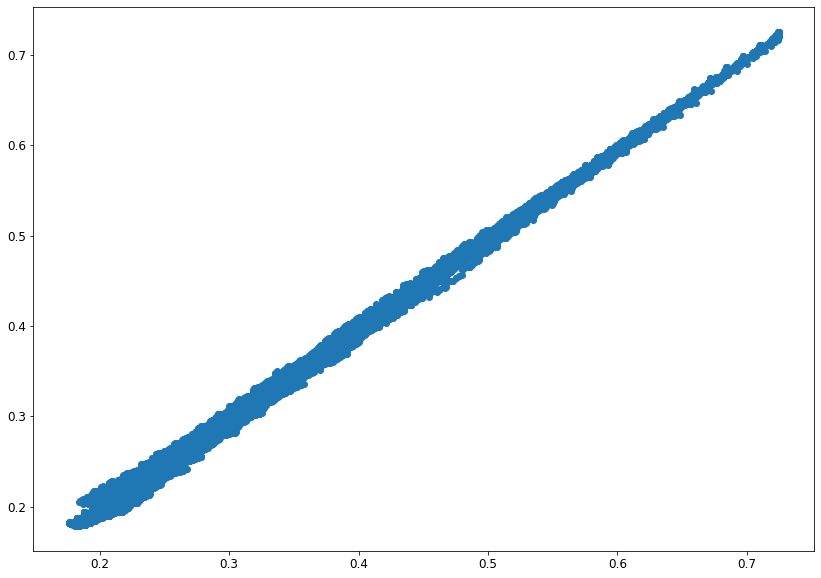

In [546]:
plt.plot(yy, full_models_results_y, 'o')
# plt.plot(yy, models_results_y, 'o', mfc='none');

# alternative idea

Why don't we just the DT to build a domain decomposition and then fit a linear or quadratic or cubic function to the data?

This is basically interpolation but without the need to store the data?

To determine which node to use we just pass the test point through the decision tree

In [547]:
# X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_udt, y_udt, test_size=0.33, random_state=42)
# clf_new = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=100).fit(X_train, y_train)
# print(clf_new.score(X_test, y_test))
# leaf_nodes = pd.DataFrame(data=clf_new.apply(dfX), columns=['leaf'])

In [548]:
leaf_nodes = pd.DataFrame(data=clf.apply(dfX), columns=['leaf'])

In [549]:
leaf_nodes.value_counts()

leaf
1075    175
2443    168
2417    168
1474    168
671     165
       ... 
1151     63
488      60
197      60
1292     60
80       58
Length: 1233, dtype: int64

In [550]:
# index to leaf_id
leaf_dict = leaf_nodes.value_counts().reset_index()['leaf'].to_dict()
leaf_dict

{0: 1075,
 1: 2443,
 2: 2417,
 3: 1474,
 4: 671,
 5: 849,
 6: 1768,
 7: 532,
 8: 857,
 9: 1509,
 10: 734,
 11: 1385,
 12: 1102,
 13: 1534,
 14: 30,
 15: 428,
 16: 639,
 17: 2058,
 18: 2392,
 19: 1554,
 20: 2397,
 21: 1096,
 22: 87,
 23: 1870,
 24: 2049,
 25: 877,
 26: 232,
 27: 173,
 28: 1436,
 29: 216,
 30: 1374,
 31: 198,
 32: 2338,
 33: 1990,
 34: 1556,
 35: 288,
 36: 145,
 37: 2340,
 38: 1747,
 39: 1107,
 40: 1109,
 41: 998,
 42: 2281,
 43: 1784,
 44: 1787,
 45: 2009,
 46: 1805,
 47: 809,
 48: 742,
 49: 1806,
 50: 1985,
 51: 2303,
 52: 394,
 53: 1840,
 54: 444,
 55: 482,
 56: 483,
 57: 494,
 58: 495,
 59: 302,
 60: 496,
 61: 2288,
 62: 1841,
 63: 238,
 64: 303,
 65: 2019,
 66: 304,
 67: 678,
 68: 2464,
 69: 346,
 70: 2251,
 71: 947,
 72: 1183,
 73: 1182,
 74: 946,
 75: 2157,
 76: 1217,
 77: 1457,
 78: 1473,
 79: 924,
 80: 1413,
 81: 2126,
 82: 1477,
 83: 1120,
 84: 1223,
 85: 1417,
 86: 2150,
 87: 1367,
 88: 1946,
 89: 1495,
 90: 1965,
 91: 1514,
 92: 2094,
 93: 775,
 94: 244,
 95:

In [551]:
dfX_leaf = pd.merge(dfX, leaf_nodes, left_index=True, right_index=True)

In [552]:
dfX_leaf

q    s1        s2  leaf
0        4.0  0.00  0.000000    11
1        4.0  0.00  0.020204    11
2        4.0  0.00  0.040408    11
3        4.0  0.00  0.060612    11
4        4.0  0.00  0.080816    14
...      ...   ...       ...   ...
124995  10.0  0.99  0.909184  2464
124996  10.0  0.99  0.929388  2464
124997  10.0  0.99  0.949592  2464
124998  10.0  0.99  0.969796  2464
124999  10.0  0.99  0.990000  2464

[125000 rows x 4 columns]

In [553]:
X_train, X_test, y_train, y_test = {}, {}, {}, {}
for k, v in leaf_dict.items():
    print(k, v)
    mask = dfX_leaf['leaf'] == v
    X = dfX_leaf[mask].drop(columns='leaf')
    y = dfy[mask]
    X_train[v], X_test[v], y_train[v], y_test[v] = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

0 1075
1 2443
2 2417
3 1474
4 671
5 849
6 1768
7 532
8 857
9 1509
10 734
11 1385
12 1102
13 1534
14 30
15 428
16 639
17 2058
18 2392
19 1554
20 2397
21 1096
22 87
23 1870
24 2049
25 877
26 232
27 173
28 1436
29 216
30 1374
31 198
32 2338
33 1990
34 1556
35 288
36 145
37 2340
38 1747
39 1107
40 1109
41 998
42 2281
43 1784
44 1787
45 2009
46 1805
47 809
48 742
49 1806
50 1985
51 2303
52 394
53 1840
54 444
55 482
56 483
57 494
58 495
59 302
60 496
61 2288
62 1841
63 238
64 303
65 2019
66 304
67 678
68 2464
69 346
70 2251
71 947
72 1183
73 1182
74 946
75 2157
76 1217
77 1457
78 1473
79 924
80 1413
81 2126
82 1477
83 1120
84 1223
85 1417
86 2150
87 1367
88 1946
89 1495
90 1965
91 1514
92 2094
93 775
94 244
95 531
96 530
97 1001
98 257
99 1059
100 1085
101 1812
102 2268
103 751
104 858
105 820
106 819
107 1234
108 1709
109 944
110 310
111 463
112 2093
113 682
114 681
115 762
116 2211
117 266
118 574
119 316
120 1189
121 588
122 180
123 1147
124 1962
125 2456
126 450
127 605
128 2054
129 618


In [554]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [611]:
pipelines={}
for k in X_train.keys():
    polynomial_features = PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)
    linear_regression = LinearRegression()
    pipelines[k] = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipelines[k].fit(X_train[k], y_train[k])

In [612]:

pd.DataFrame(data=np.c_[pipelines[list(pipelines.keys())[0]]['polynomial_features'].get_feature_names_out(), pipelines[list(pipelines.keys())[0]]['linear_regression'].coef_], columns=['var', 'coeff'])

var       coeff
0         1         0.0
1         q   17.428704
2        s1   -0.076883
3        s2   -0.134564
4       q^2  135.327245
5      q s1    0.192775
6      q s2    7.585348
7      s1^2    0.387683
8     s1 s2   -0.500226
9      s2^2   -0.700487
10      q^3 -649.570525
11   q^2 s1   -0.079797
12   q^2 s2   -0.942306
13   q s1^2    0.699837
14  q s1 s2    0.040656
15   q s2^2   -0.410513
16     s1^3    -3.05822
17  s1^2 s2   -0.179122
18  s1 s2^2     0.25636
19     s2^3     1.88169

In [613]:
polynomial_models_ypred = {}
for k in X_test.keys():
    polynomial_models_ypred[k] = pipelines[k].predict(X_test[k])

In [614]:
polynomial_models_ypred_all = np.concatenate([polynomial_models_ypred[k] for k in polynomial_models_ypred.keys()])

In [615]:
polynomial_models_results = {}
for k in X_test.keys():
    polynomial_models_results[k] = [tf.keras.metrics.mean_absolute_error(y_test[k].values, polynomial_models_ypred[k]).numpy()]

In [616]:
polynomial_models_results;

In [617]:
polynomial_models_results=pd.DataFrame.from_dict(polynomial_models_results, orient='index', columns=['polynomial'])

In [618]:
polynomial_models_results

polynomial
1075    0.001859
2443    0.001008
2417    0.002222
1474    0.006927
671     0.000637
...          ...
1151    0.000104
488     0.000053
197     0.004811
1292    0.003077
80      0.000048

[1233 rows x 1 columns]

<AxesSubplot:>

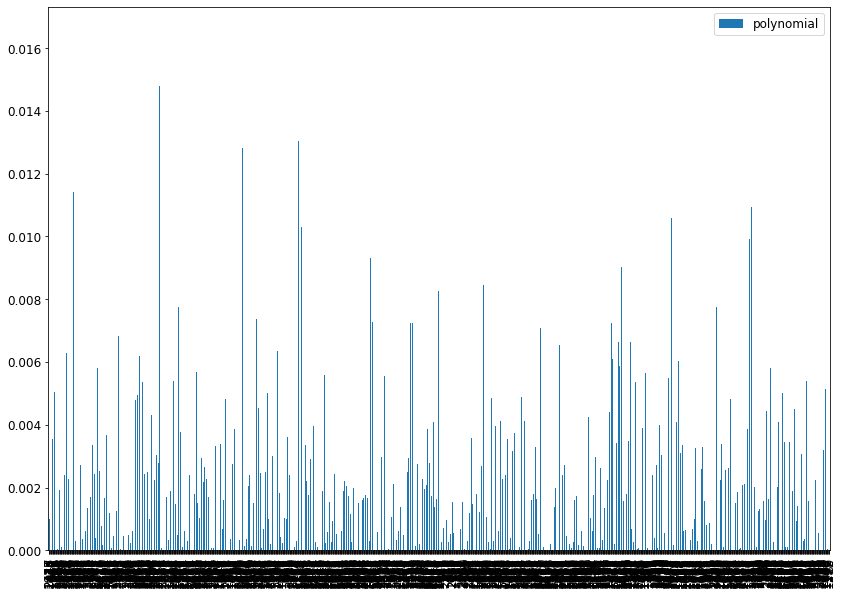

In [619]:
polynomial_models_results.plot(kind='bar')

In [620]:
# results = pd.concat((model_full_results, models_results, polynomial_models_results), axis=1)
results = pd.concat((model_full_results, polynomial_models_results), axis=1)

<AxesSubplot:>

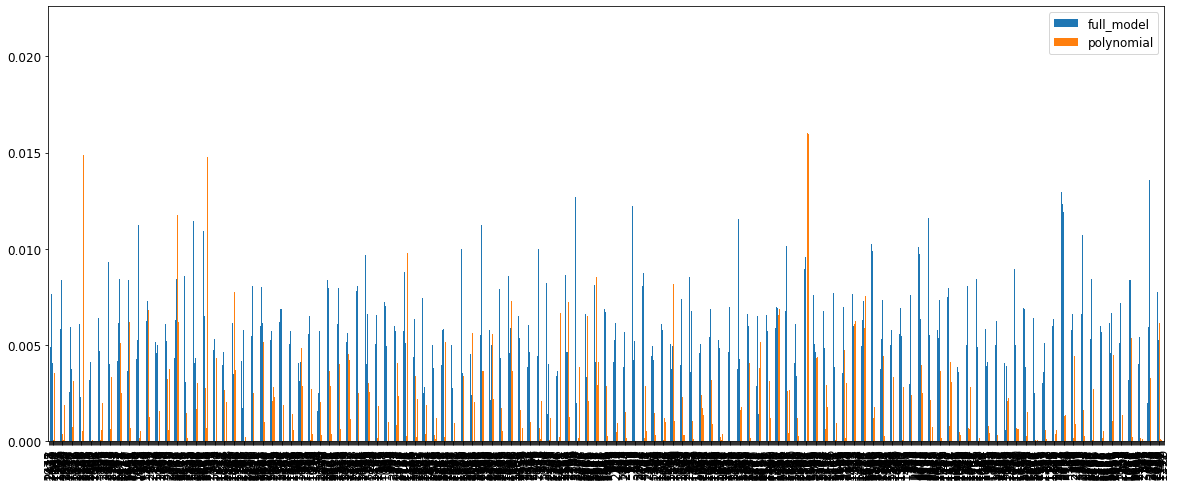

In [621]:
results.plot(kind='bar', figsize=(20,8))

In [622]:
plt.plot(yy, full_models_results_y, 'o')
# plt.plot(yy, models_results_y, 'o', mfc='none');
plt.plot(yy, polynomial_models_ypred_all, 'o', mfc='none', alpha=0.5);
plt.plot([0.15,0.75], [0.15,0.75], ls='--', alpha=0.5)

In [623]:
full_models_diff = yy-full_models_results_y
poly_diff = yy-polynomial_models_ypred_all

Text(0.5, 1.0, 'error')

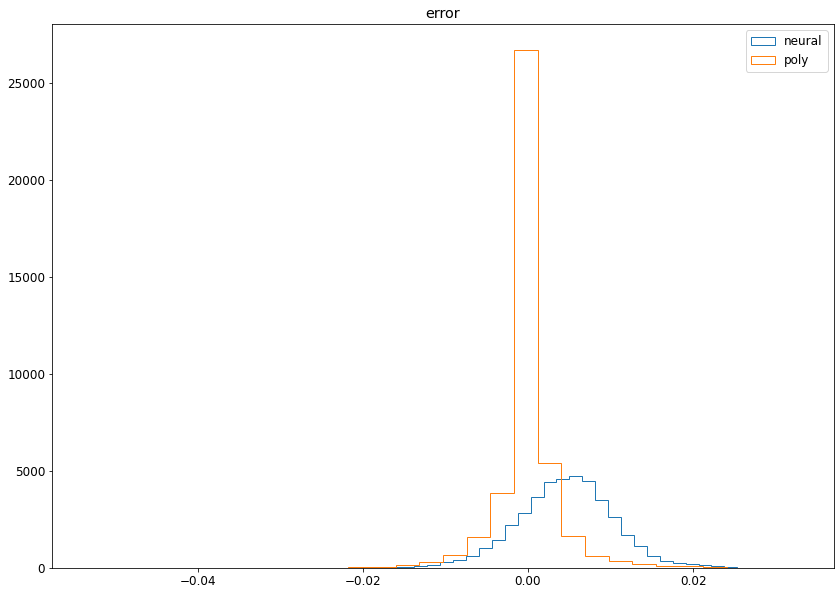

In [624]:
plt.hist(full_models_diff, histtype='step', label='neural', bins=30)
plt.hist(poly_diff, histtype='step', label='poly', bins=30)
plt.legend()
plt.title("error")

In [625]:
plt.hist(np.log10(np.abs(full_models_diff)), histtype='step', label='neural', bins=30)
plt.hist(np.log10(np.abs(poly_diff)), histtype='step', label='poly', bins=30)
plt.legend()
plt.title("log10(abs(error))")

Text(0.5, 1.0, 'log10(abs(error))')

In [626]:
# at this point we can threshold on the error in each leaf node
# for each leaf node that is above threshold we can
# generate more samples (e.g. with GMM, if we have already sampled enough then we can probably just build a simple GMM for just the samples in the given leaf node...)
# are further sub-divide to hopefully build a simpler model
# 